In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm


1. Our grid will have two important integers for each index, a value to represent the water units, and a value to represent the land units. Currently, I will probably have these as two separate nxn grids as I don't know how I want to interact with my grids yet.
2. We have a random location selected for water runoff. This is based off of a neighboring surface height being lower than parent chosen location. If lower, water units are brought to balance these two sites. We will be working with the assumption that if the balance is uneven, it is the neighboring location which will win this balancing tug-of-war.
3. For each unit of water transfered between parent and neighbor, a unit of land (from parent?) will be deleted (as runoff) but only if the neighboring land is lower than parent land.
4. Additional water fall on a site as precipitation at random intervals. We will take this to mean a random neighborhood (of unknown design) will receive a random amount of new water units to further the systems development. This is how a perfectly flat initial state can be initialized further perhaps. We will take this as a small variable which can trigger a precipitation event. We will constantly roll the die to see if this event is triggered, in between system/lattice updates.
5. I will be copying over some bootstraps from Profs notebook for ease of implementation.

In [10]:
class ErosionModel:
    """
    Erosion model class working from the logical architecture provided from Kramer and Marder. I've left snippets of explanations and short discussions on the subsequent methods and such but here is a general overview. We start with an n by m land matrix and water matrix. I am setting m to be 3 times as large as n, so it is a horizontal rectangle. Initially, the system is perfectly level for provided values of land and water. Randomly, lattices are selected, so we check the 4 neighboring elements to see if their surfaces (land units + water units at that lattice location) are lower than the selected lattice's. The order we check appears to impact the results of the model. If a neighbor surface is lower than selected lattice's we work to balance these two surfaces by transfering water from the high to the low. In the event of an odd transfer, the neighbor picks up the extra unit. This is not detailed in Kramer and Marder so this is an assumption I've made. I've also made the assumption that we are only checking the 4 linear neighbors and not the ring of 8 (Currently checking 4 diagonal, not linear). In the event of transferring k units of water we must also transfer k units of land, but only if the neighbor's land value is smaller than the selected lattice's land value. When transferring land, this land is deleted as it is picked up by the flowing water and dispersed out of the system. There is an important outflow boundary at the bottom most row of the grid. When the southern border (outside the grid space) is checked as a neighbor of a lattice in the last row, all water is deleted from lattice point and land is deleted as if it were a regular neighbor interaction. This is another fundamental assumption not fully detailed by Kramer and Marder. Also, this boundary is the cause of the evolution of the system from a perfectly homogenous one. Lastly, precipitation events (again not fully detailed by Kramer and Marder) randomly occur and I have taken it to occur instantaneously between system steps. Please review that section for further explanation, but basically, this adds water to the system and random locations.
    """
    
    def __init__(self, n=10,  water_height=5, land_height=50, random_state=None):
        self.n = n
        self.m = self.n * 3
        self.water = np.full((self.n, self.m), water_height, dtype=int)
        self.land = np.full((self.n, self.m), land_height, dtype=int)
        np.random.seed(random_state) # Set the random seed
        self.history =[self.land.copy()] # Not sure how to play with the history for this
        self.water_history = np.zeros((self.n, self.m), dtype=int)


    def step(self):
        """
        Here we are simply selecting a random point and checking for a valid neighbor. For that location, we need to see if any of its neighbors have a smaller surface value. We call that method and if a valid index is returned, we call the balancing method, as we need to flow units to balance these surfaces.
        :return: None
        """
        
        i, j = np.random.choice(self.n), np.random.choice(self.m)
        neighbor = self._neighbor_check(i, j) # A tuple or None
        if neighbor:
            self._surface_balance(i, j, neighbor[0], neighbor[1])
        return
    
    
    def _neighbor_check(self, i, j):
        """
        Check the 4 diagonally neighboring lattices, to see if any have lower surface values. If so, return neighbor index. Else, return None. I currently have the list of neighbors to check from, randomized. Furthermore, I am unsure if Kramer and Marder check all neighbors, or just a single random one. In practice, I would expect we should check all, as I am doing here. I might also try checking all 8 neighbors instead of the 4 diagonal as I currently am. I previously checked 4 linear neighbors but opted for diagonals due to diagonal patterns I noticed in Kramer and Marder's graph.
        :param i: row index of random location, int
        :param j: column index of random location, int
        :return: index tuple of neighbor or None, tuple or None
        """
        
        indices = [(i + 1, j + 1), (i + 1, j - 1), (i - 1, j - 1), (i - 1, j + 1)]
        np.random.shuffle(indices)
        for i_n, j_n in indices: # Notice the biased order
            if not (0 <= i_n <= self.n and 0 <= j_n < self.m): # Here I enforce the bottom edge outflow boundary condition
                continue
            
            # We check if it is an outflow point or if the surfaces are unbalanced
            if i_n == self.n or self.water[i_n, j_n] + self.land[i_n, j_n] < self.water[i, j] + self.land[i, j]:
                return i_n, j_n
        return None
        
    
    def _surface_balance(self, i, j, i_n, j_n):
        """
        For a surface difference between parent lattice and neighbor lattice, we calculate how much water is transferred between the two, to balance them. We are also performing the land transfer here as it is quite simple and requires transfer. A couple key assumptions are made here, the first is that in the event of an odd difference, it is the neighbor site who we will skew towards. Secondly, there is lots of important and complicated logic for what happens when there is not enough land, or not enough water to transfer between sites. I feel I need to revisit what is happening at some of the extrema cases for this transfer logic.
        :param i: row index of parent lattice, int
        :param j: column index of parent lattice, int
        :param i_n: row index of neighbor lattice, int
        :param j_n: column index of neighbor lattice, int
        :return: None
        """
        
        if i_n == self.n: # Logic defining southern outflow condition
            outflow = self.water[i, j]
            self.water_history[i, j] += outflow # History commit
            self.water[i, j] = 0
            self.land[i, j] -= outflow if self.land[i, j] >= outflow else self.land[i, j] # Prevent negative land
            return
        
        # The up-rounded transfer value between the two surfaces
        transfer = int(np.ceil((self.land[i, j] + self.water[i, j] - self.land[i_n, j_n] - self.water[i_n, j_n])/2)) 
        transfer = transfer if self.water[i, j] >= transfer else self.water[i, j] # Prevent negative water units
        
        # History commit
        self.water_history[i, j] += transfer
        
        # Water transfer
        self.water[i, j] -= transfer
        self.water[i_n, j_n] += transfer
        
        """Investigate imposing a maximum land transference here. Currently, an unlimited amount of land is able to be transported away if there is even a single unit of difference."""
        # If neighbor has less land, transfer units of land away
        if self.land[i, j] > self.land[i_n, j_n]:
            self.land[i, j] -= transfer if self.land[i, j] >= transfer else self.land[i, j] # Prevent negative land
            
        return


    def _precipitate(self, sigma_n=5, sigma_m=5, intensity=1):
        """
        I will briefly comment that the exact structure of how the precipitation occurs requires more thorough analysis and implementation. I have gone through a few iterations of the nature of this precipitation. Currently, we are creating an influx array which is like a 2D gaussian distribution as a heatmap, scaled by the intensity parameter. Sigma n and m control the nature of the spread of this 2D gaussian. We generate a random lattice point to act as the center for this distribution. I have concerns that my current method implementation is slow.
        :param sigma_n: precipitation spread along n dimension, int
        :param sigma_m: precipitation spread along m dimension, int
        :param intensity: intensity of precipitation event, int
        :return: None
        """
    
        center_n, center_m = np.random.randint(0, self.n), np.random.randint(0, self.m)  # Center of the normal distribution
        precipitation = self._create_influx_array(center_n, center_m, sigma_n=sigma_n, sigma_m=sigma_m, intensity=intensity)     
        self.water += precipitation
        return


    def _create_influx_array(self, center_n, center_m, sigma_n=5, sigma_m=5, intensity=1):
        """
        Create an n by m array according to a 2D gaussian distribution, centered around center_n and center_m.
        :param center_n: center of normal distribution along n dimension, int
        :param center_m: center of normal distribution along m dimension, int
        :param sigma_n: distribution along n dimension, float
        :param sigma_m: distribution along m dimension, float
        :param intensity: scaling of the central peak, int
        :return: n by m grid of integers
        """
        
        # Create a grid of coordinates
        x = np.arange(0, self.n)
        y = np.arange(0, self.m)
        X, Y = np.meshgrid(x, y, indexing='ij')
        
        # 2D Gaussian distribution
        gauss = np.exp(-(((X - center_n)**2) / (2 * sigma_n**2) + ((Y - center_m)**2) / (2 * sigma_m**2)))
        rounded_array = np.floor(gauss * intensity).astype(int)
        
        return rounded_array
        
    
    def simulate(self, n_step, precip_chance=0.1, precip_intensity=1, precip_x_range=4, precip_y_range=4):
        """
        We will simply use this to run for a certain duration, calling step() method each time. Before looping, we load a list called precip_steps which is a boolean list of size n_step, indicating whether a particular step will have a precipitation event. This event will be seen as an instantaneous addition of water units to the system, for some
        area. We will offload the logic for this event to another method, but we will keep the random precipitation chance
        here. I am unsure how to analyze the history of this model so consider changing what is record here. I will leave it commented out as it appears to effectively double runtime.
        :param n_step: simulation iterations, int
        :param precip_chance: percent chance of precipitation event, float
        :param precip_intensity: intensity of precipitation event, int
        :param precip_x_range: horizontal spread of precipitation event, int
        :param precip_y_range: vertical spread of precipitation event, int
        :return: None
        """
        
        precip_steps = np.random.choice([0, 1], size=n_step, p=[1 - precip_chance, precip_chance])
        for step in range(n_step):
            if precip_steps[step]:
                self._precipitate(intensity=precip_intensity, sigma_n=precip_x_range, sigma_m=precip_y_range)
            self.step()
            # self.history.append(self.land.copy() + self.water.copy())
            
        return


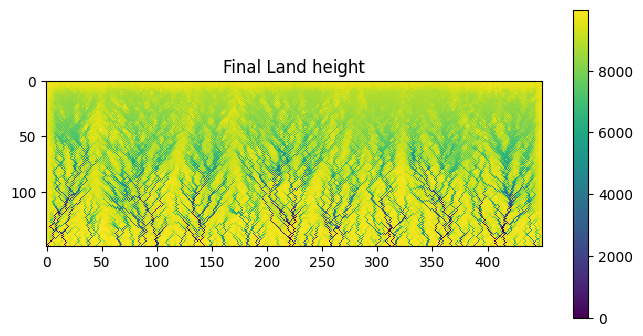

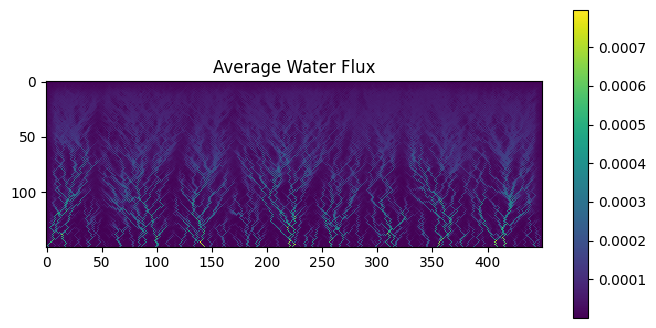

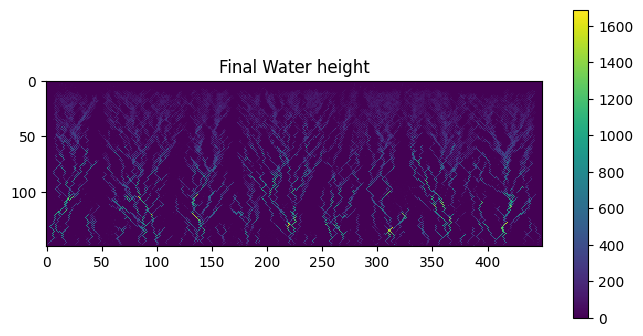

In [30]:
"""
From what I can tell, I have something that seems pretty similar to Kramer and Marders graph but I think I am having the most issue with the visualization of the results. I'm not too familiar with different visualization techniques in matplotlib. Also, Kramer and Marder say that their plot was a time averaged flow of through the network. They define this as "the total number of water units which leave a particular site during N time steps, divided by N". I am unsure how I should try to capture this differentiation in an optimal manner.

As far as parameters are concerned, try experimenting with all of them and watch how the end minimum land and water values compare. Kramer and Marder never mentioned a max land depth or water to land ratio. Well they kind of did at the beginning of the paper but I mostly brushed over that as they were trying to validate some of their other equations with real data and I didn't care.
"""

# Current parameters take about 50 seconds to run
model = ErosionModel(n=150, land_height=10000, random_state=0)

Steps = 3 * 10**7
model.simulate(Steps, precip_chance=0.0001, precip_intensity=5, precip_x_range=8, precip_y_range=8)


Z = model.land
plt.figure(figsize=(8, 8))
plt.title('Final Land height')
plt.imshow(Z, interpolation='None') # Notice how I am power scaling this graph
plt.colorbar(shrink=0.5)
plt.show()


Z = model.water_history / Steps
plt.figure(figsize=(8, 8))
plt.title('Average Water Flux')
plt.imshow(Z, interpolation='None')
plt.colorbar(shrink=0.5)
plt.show()



Z = model.water
plt.figure(figsize=(8, 8))
plt.title('Final Water height')
plt.imshow(Z, interpolation='None')
plt.colorbar(shrink=0.5)
plt.show()


# I was trying to experiment with your all_diffs and model.history from the other notebook but it isn't intuitive to me.
# all_diffs = np.abs(np.diff(np.array(model.history), axis=0))
# # print(np.info(all_diffs))
# all_diffs[all_diffs > 0] = 1
# # all_diffs = all_diffs[np.sum(all_diffs, axis=(1, 2)) > 1] # Filter to only keep big events
# most_recent_events = np.sum(all_diffs, axis=0)
# plt.imshow(most_recent_events, cmap='inferno', interpolation='nearest');

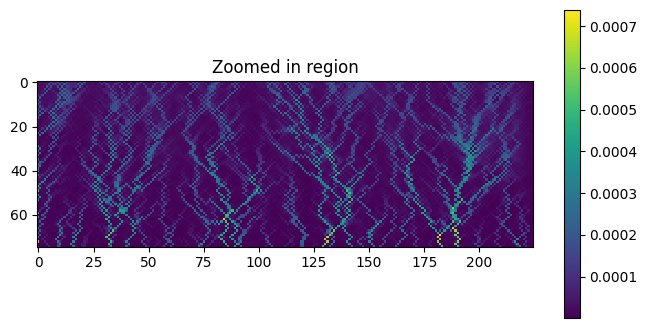

In [31]:
Z = model.water_history / Steps
plt.figure(figsize=(8, 8))
plt.title('Zoomed in region')
plt.imshow(Z[model.n//2:, model.m//2:], interpolation='None')
plt.colorbar(shrink=0.5)
plt.show()  